In [1]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier
import shap
import pickle
import cloudpickle
import numpy as np
from comparers import ModelComparer
from explainers import generate_shap_explanations
from plots import plot_decision_boundary, plot_2d, plot_feature_importance_bar, plot_feature_importance_scatter,\
                  plot_feature_effects, plot_forces
from util import calc_feature_order, calc_class_order, calc_instance_order
from helper_models import ModifiedClassifier, round_with_precision
shap.initjs()
%matplotlib inline
task_name = '06'

# Setup Task

In [2]:
X, y = make_classification(n_samples=300, n_features=2, n_redundant=0, n_informative=2,
                           n_clusters_per_class=1, class_sep=0.75, random_state=0)
feature_names = np.array(['x1', 'x2'])
n_features = len(feature_names)
n_samples = X.shape[0]

In [3]:
from sklearn.linear_model import LogisticRegression
lm = LogisticRegression()
lm.fit(X, y)
lm.intercept_, lm.coef_

(array([0.91535451]), array([[-1.76177855,  2.52385315]]))

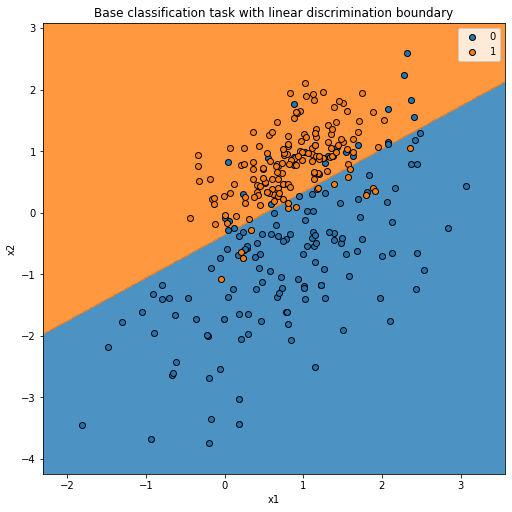

In [4]:
fig, ax = plt.subplots(figsize=(7, 7), constrained_layout=True)
plot_decision_boundary(X, y, 'Base classification task with linear discrimination boundary', feature_names,
                       predict=lm.predict, class_names=lm.classes_,
                       fig=fig, ax=ax)

In [5]:
clf_a = lm

In [6]:
class MyModifiedClassifier(ModifiedClassifier):
    def _preprocess(self, X):
        return round_with_precision(X, 1.2)
    
clf_b = MyModifiedClassifier(lm)
clf_b.fit(X, y)

MyModifiedClassifier(base_model=LogisticRegression())

In [7]:
comparer = ModelComparer(clf_a, clf_b, feature_names)
comparer.fit(X, y)
with open(task_name + '.models', 'wb') as f:
    cloudpickle.dump(comparer, f, pickle.HIGHEST_PROTOCOL)

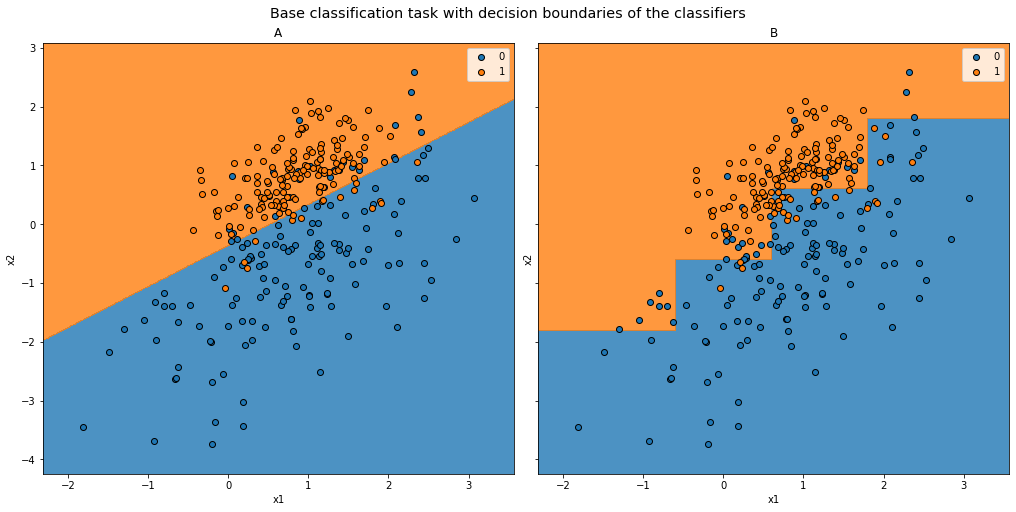

In [8]:
comparer.plot_individual_clf_decision_boundaries(X, y_true=y, kind='label')

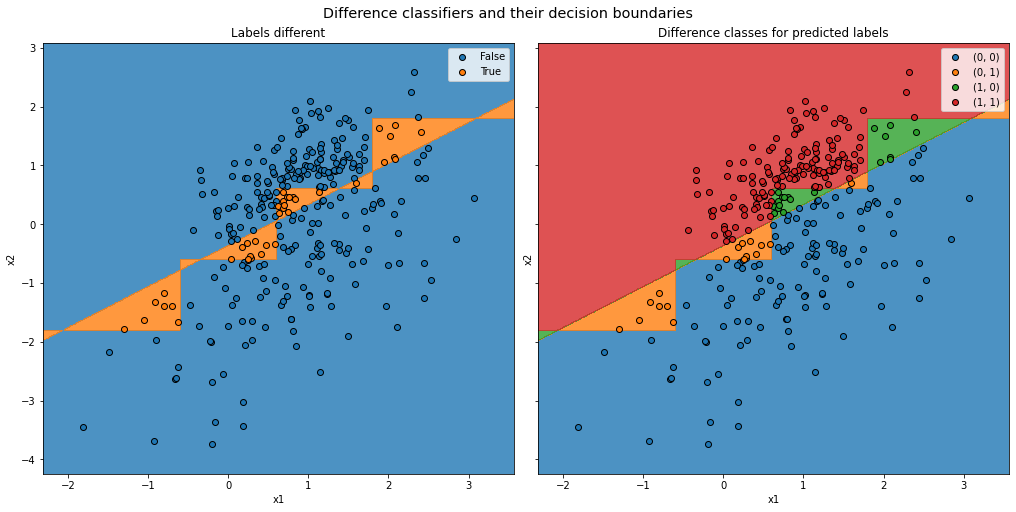

In [9]:
comparer.plot_decision_boundaries(X)

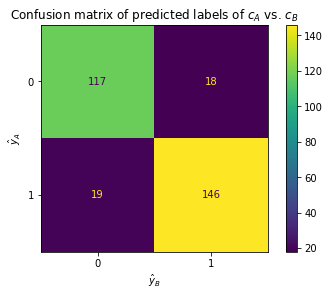

In [10]:
comparer.plot_confusion_matrix(X)

# Explain using Interpretability Methods

In [11]:
%%time
explanations = generate_shap_explanations(comparer, X, space_types=['labels'])
with open(task_name + '.expl', 'wb') as f:
    pickle.dump(explanations, f, pickle.HIGHEST_PROTOCOL)

CPU times: user 7.08 s, sys: 187 ms, total: 7.27 s
Wall time: 8.76 s


## Visualize SHAP values

### Individual explanations

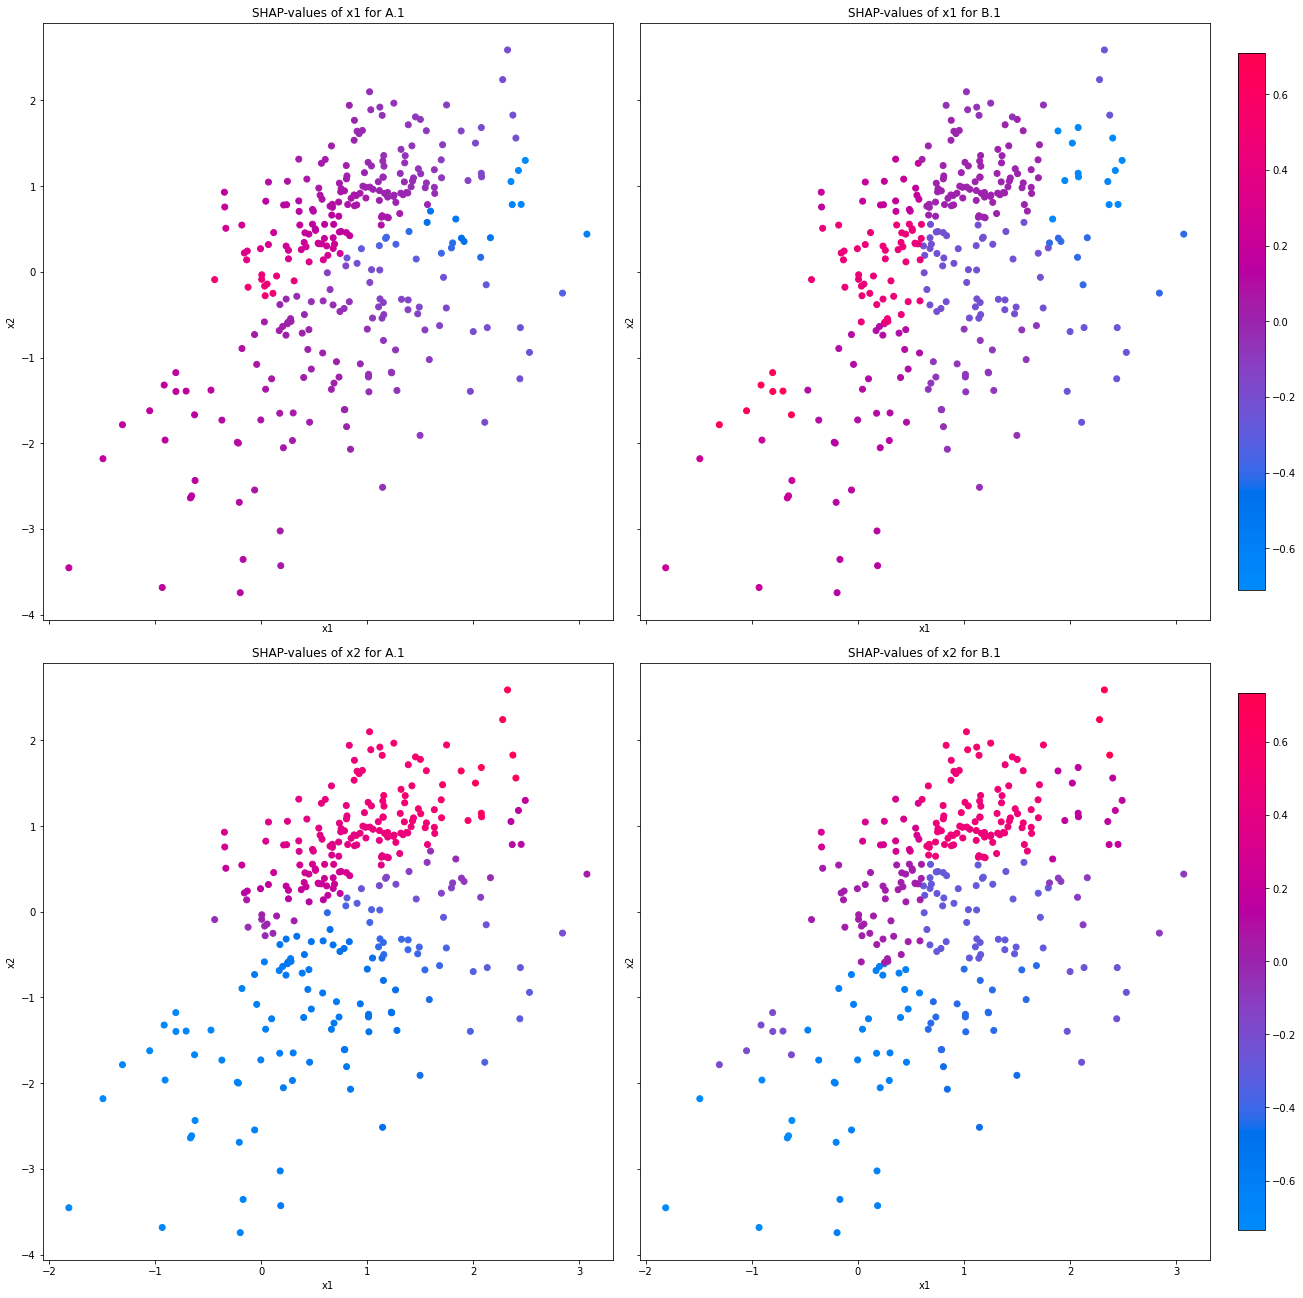

In [12]:
plot_2d(explanations.indiv.labels[:, :, 1])

### Simple subtraction explanation

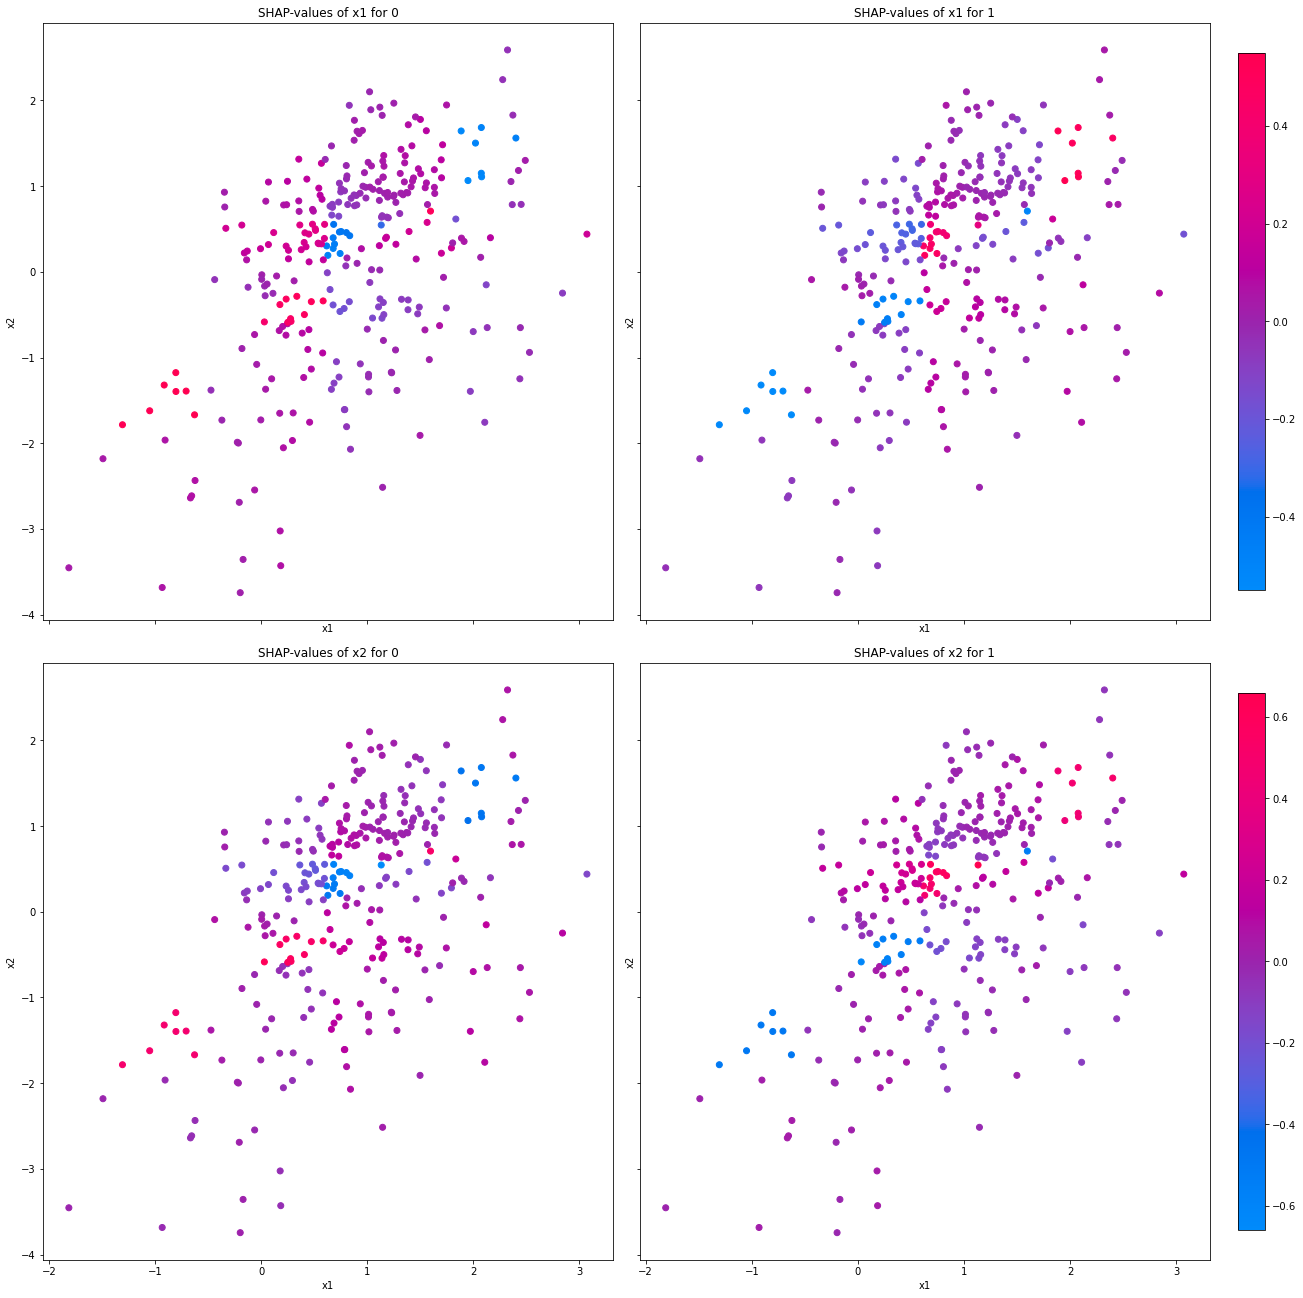

In [13]:
plot_2d(explanations.indiv_diff.labels)

### Multiclass difference classifier explanations

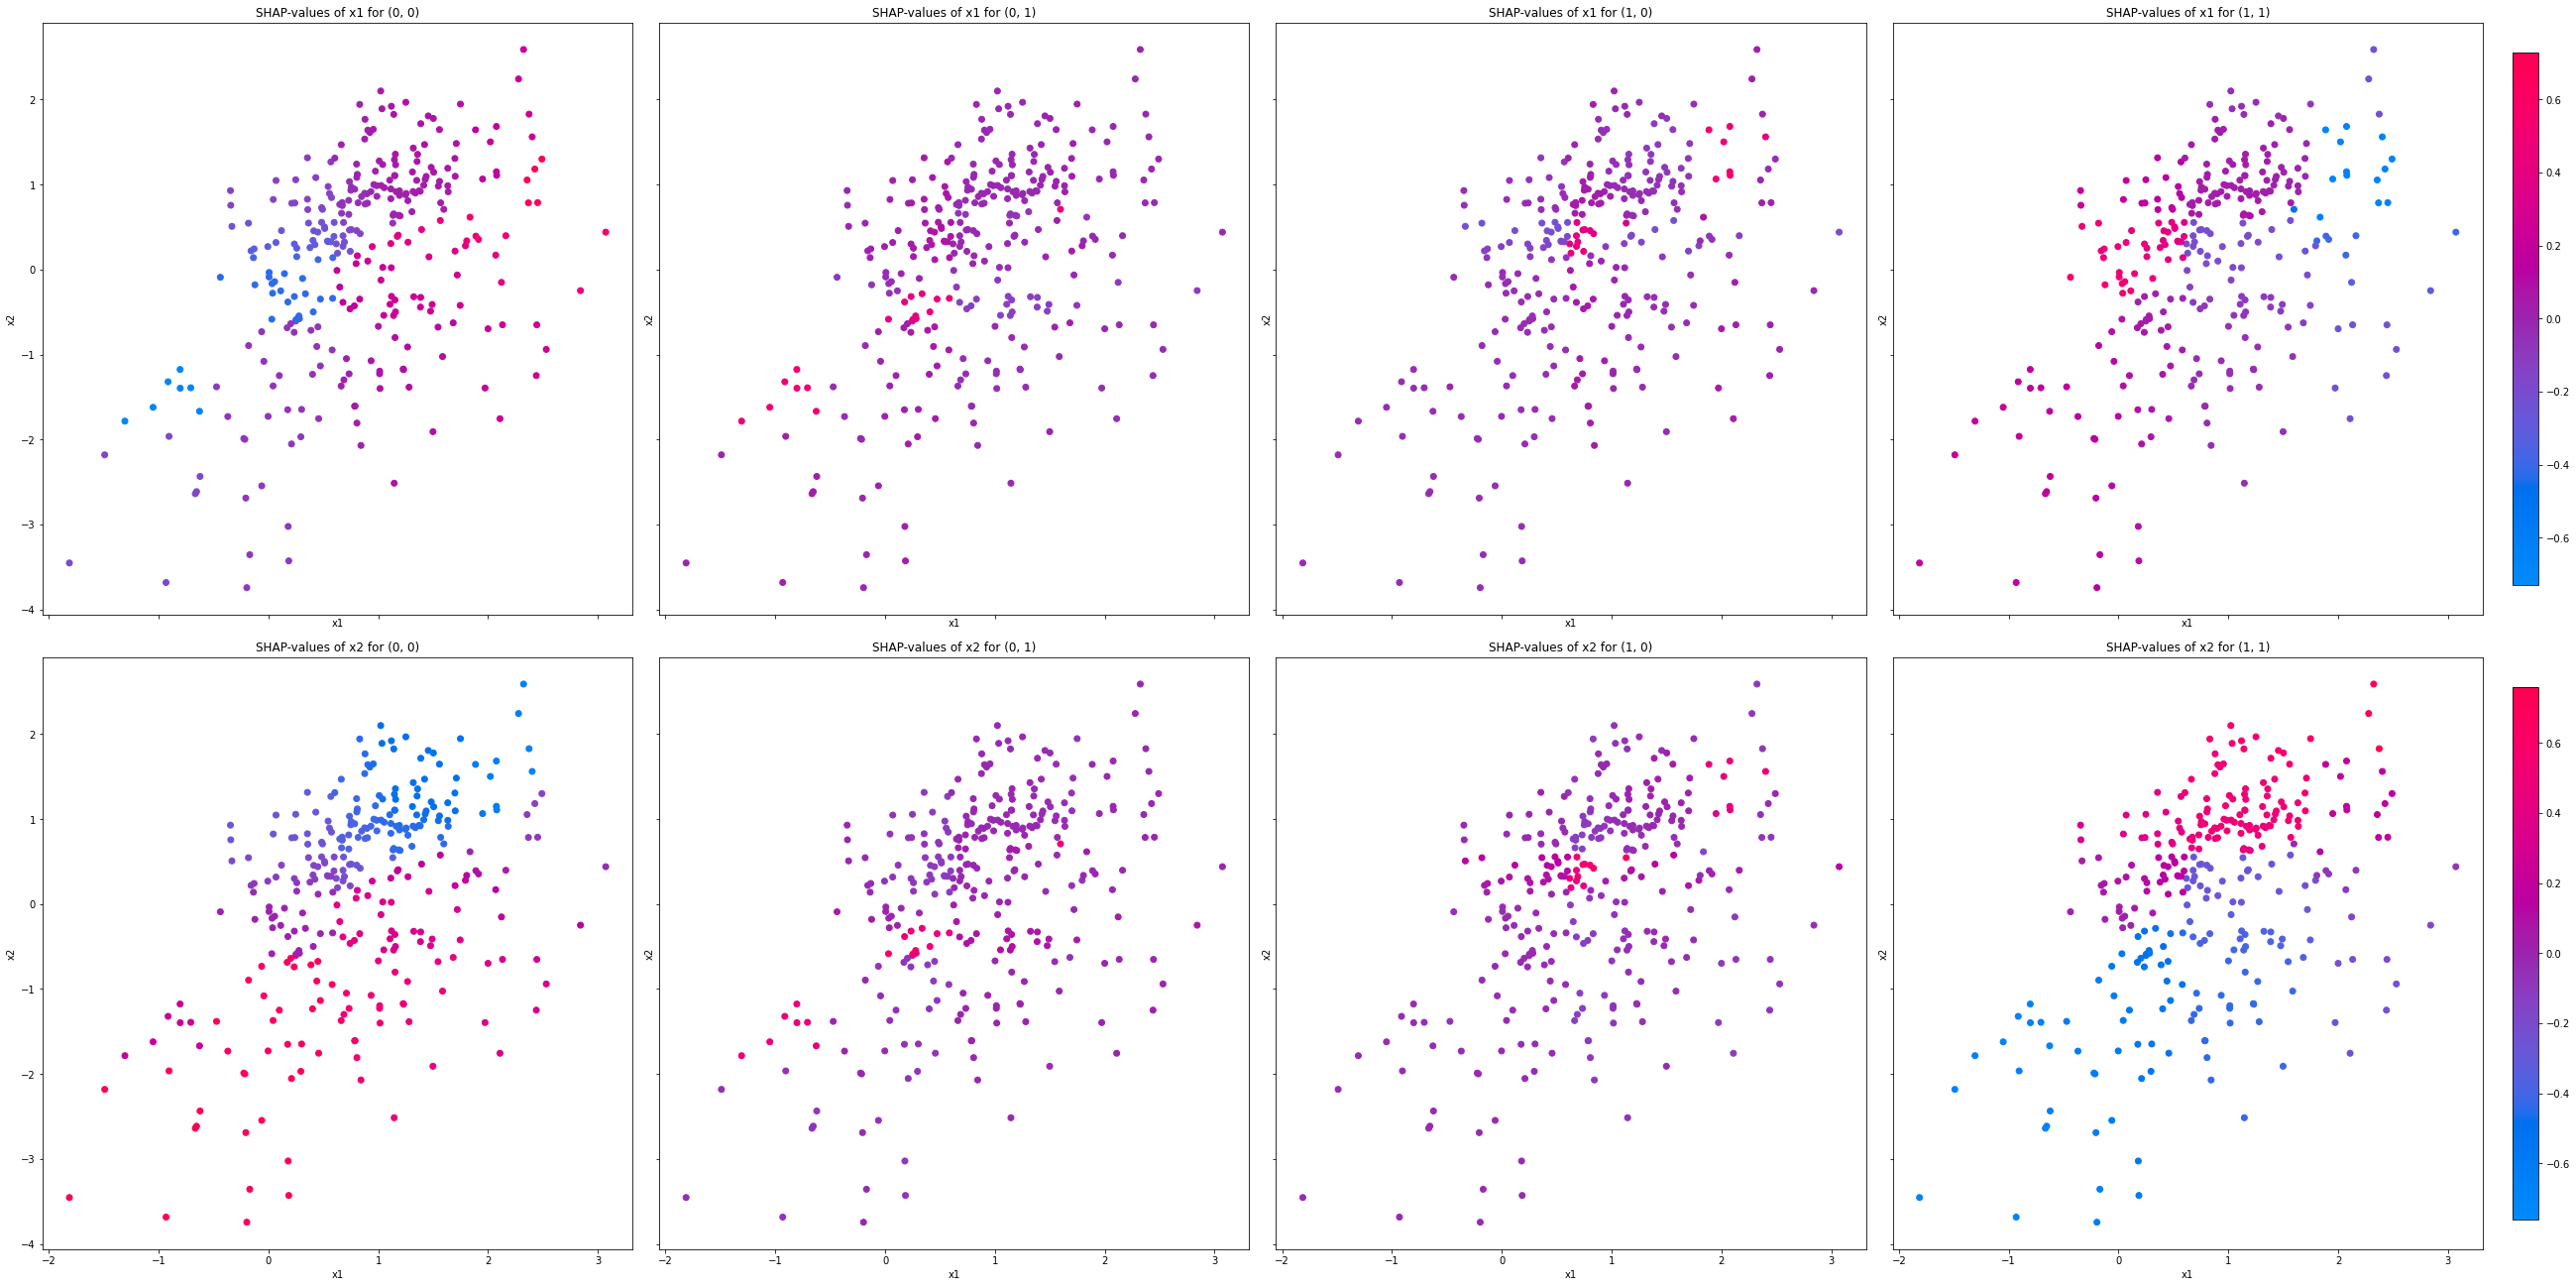

In [14]:
plot_2d(explanations.mclass_diff.labels)

## Feature importance

### Individual explanations

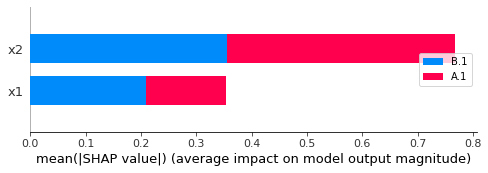

In [15]:
plot_feature_importance_bar(explanations.indiv.labels[:, :, 1])

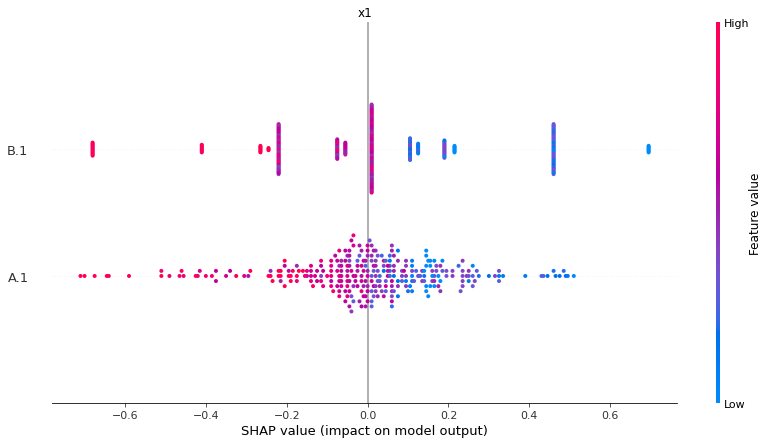

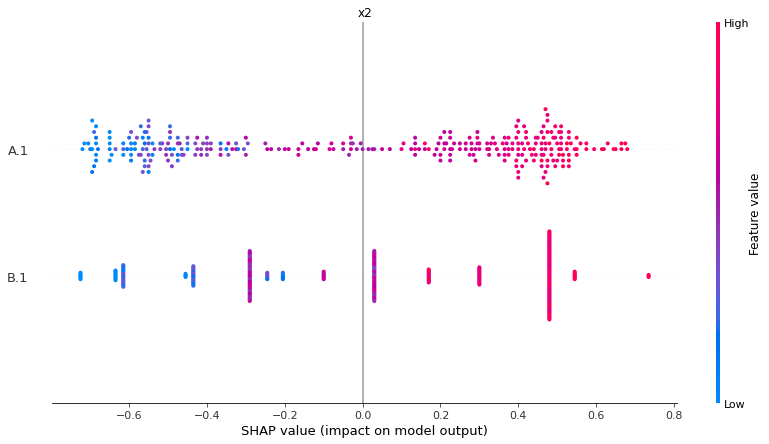

In [16]:
plot_feature_importance_scatter(explanations.indiv.labels[:, :, 1])

### Simple subtraction explanation

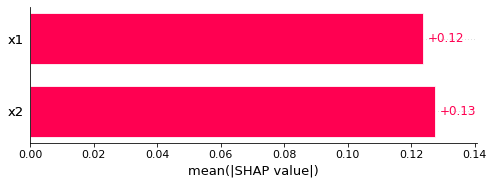

In [17]:
plot_feature_importance_bar(explanations.indiv_diff.labels[:, :, 1])

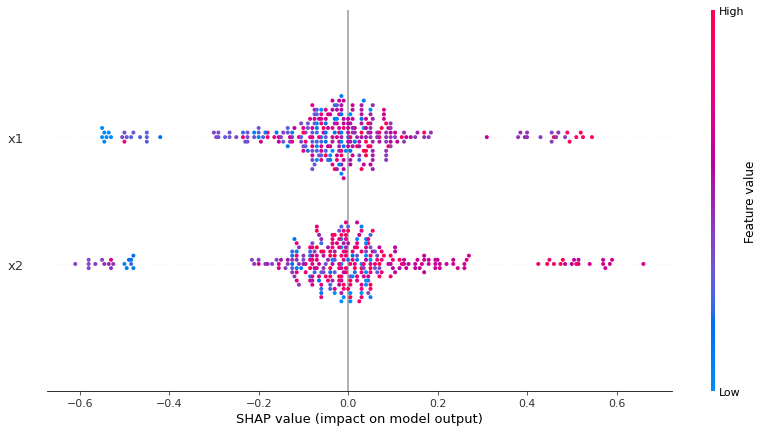

In [18]:
plot_feature_importance_scatter(explanations.indiv_diff.labels[:, :, 1])

### Multiclass difference classifier explanations

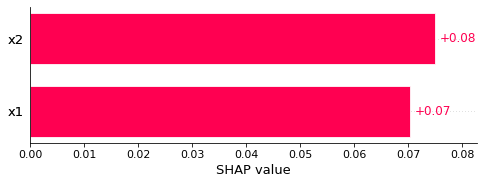

In [19]:
feature_order, feature_importance = calc_feature_order(explanations.mclass_diff.labels[:, :, comparer.difference_class_names])
plot_feature_importance_bar(feature_importance)

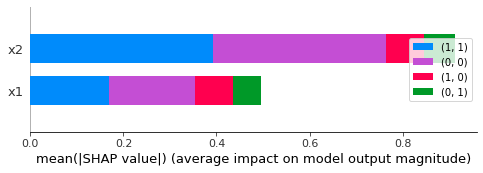

In [20]:
plot_feature_importance_bar(explanations.mclass_diff.labels)

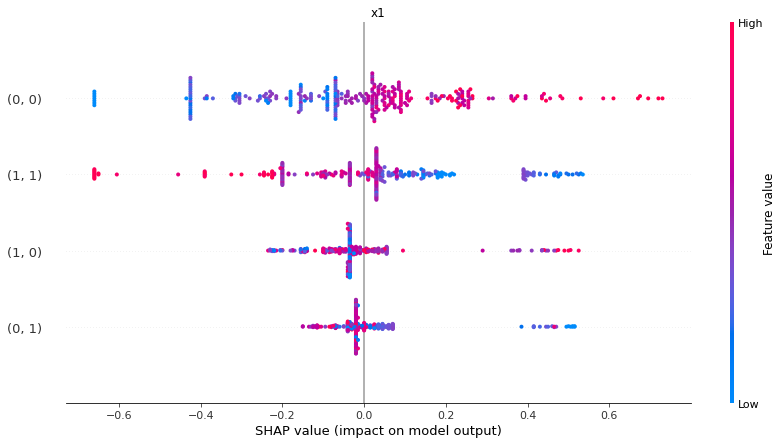

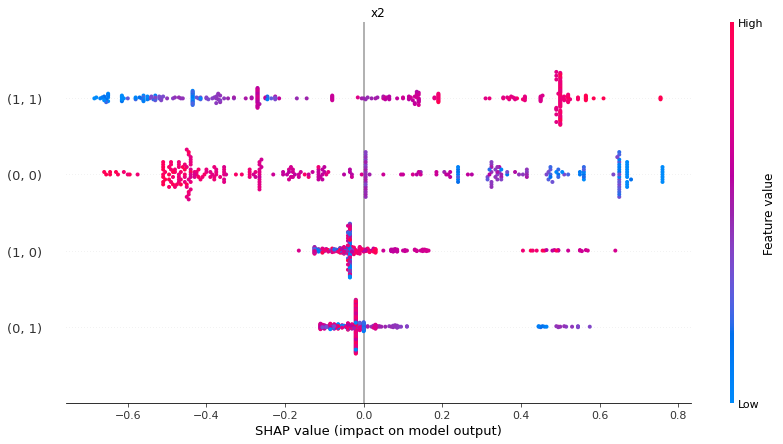

In [21]:
plot_feature_importance_scatter(explanations.mclass_diff.labels)

## Feature effects

### Individual explanations

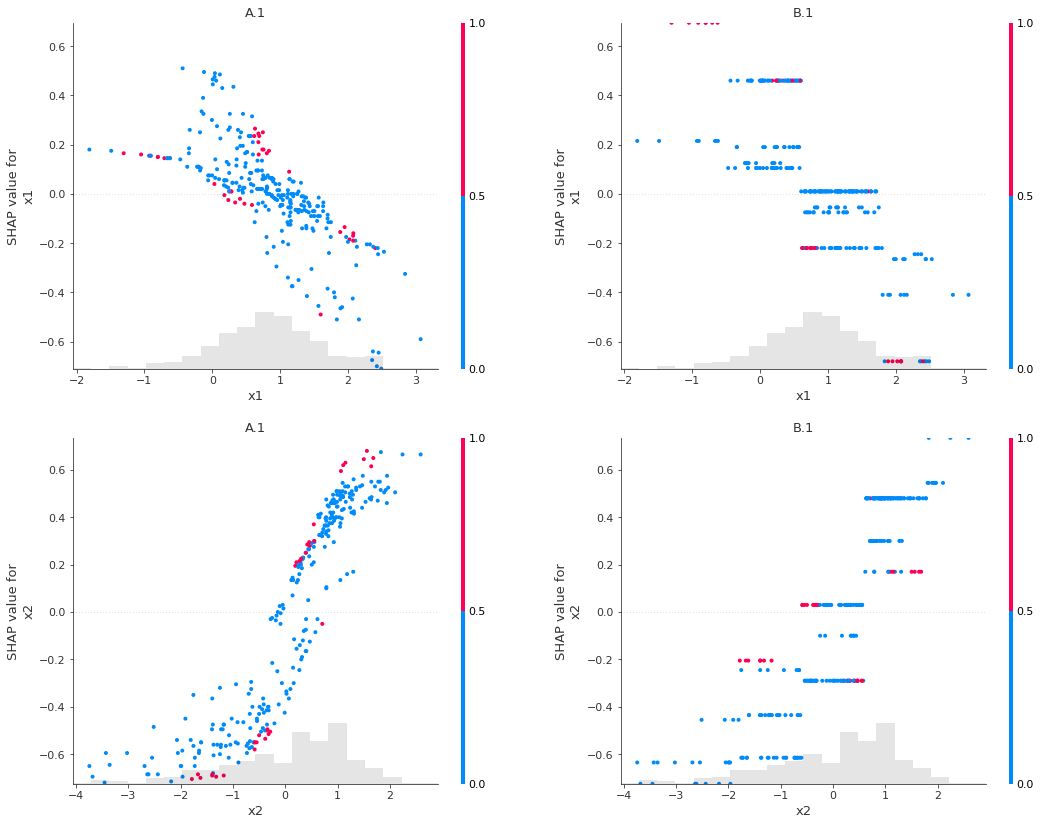

In [22]:
is_pred_diff = comparer.predict_bin_diff(explanations.data)
plot_feature_effects(explanations.indiv.labels[:, :, 1], color=is_pred_diff)

### Simple subtraction explanation

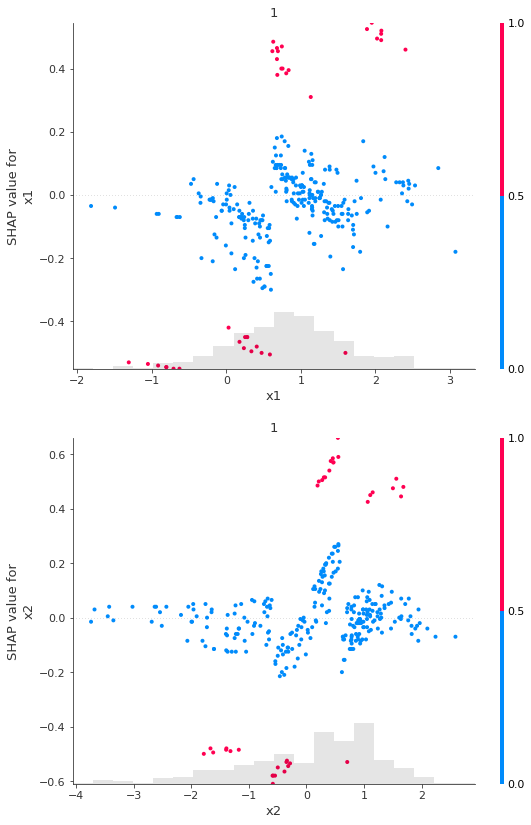

In [23]:
plot_feature_effects(explanations.indiv_diff.labels[:, :, 1], color=is_pred_diff)

### Multiclass difference classifier explanations

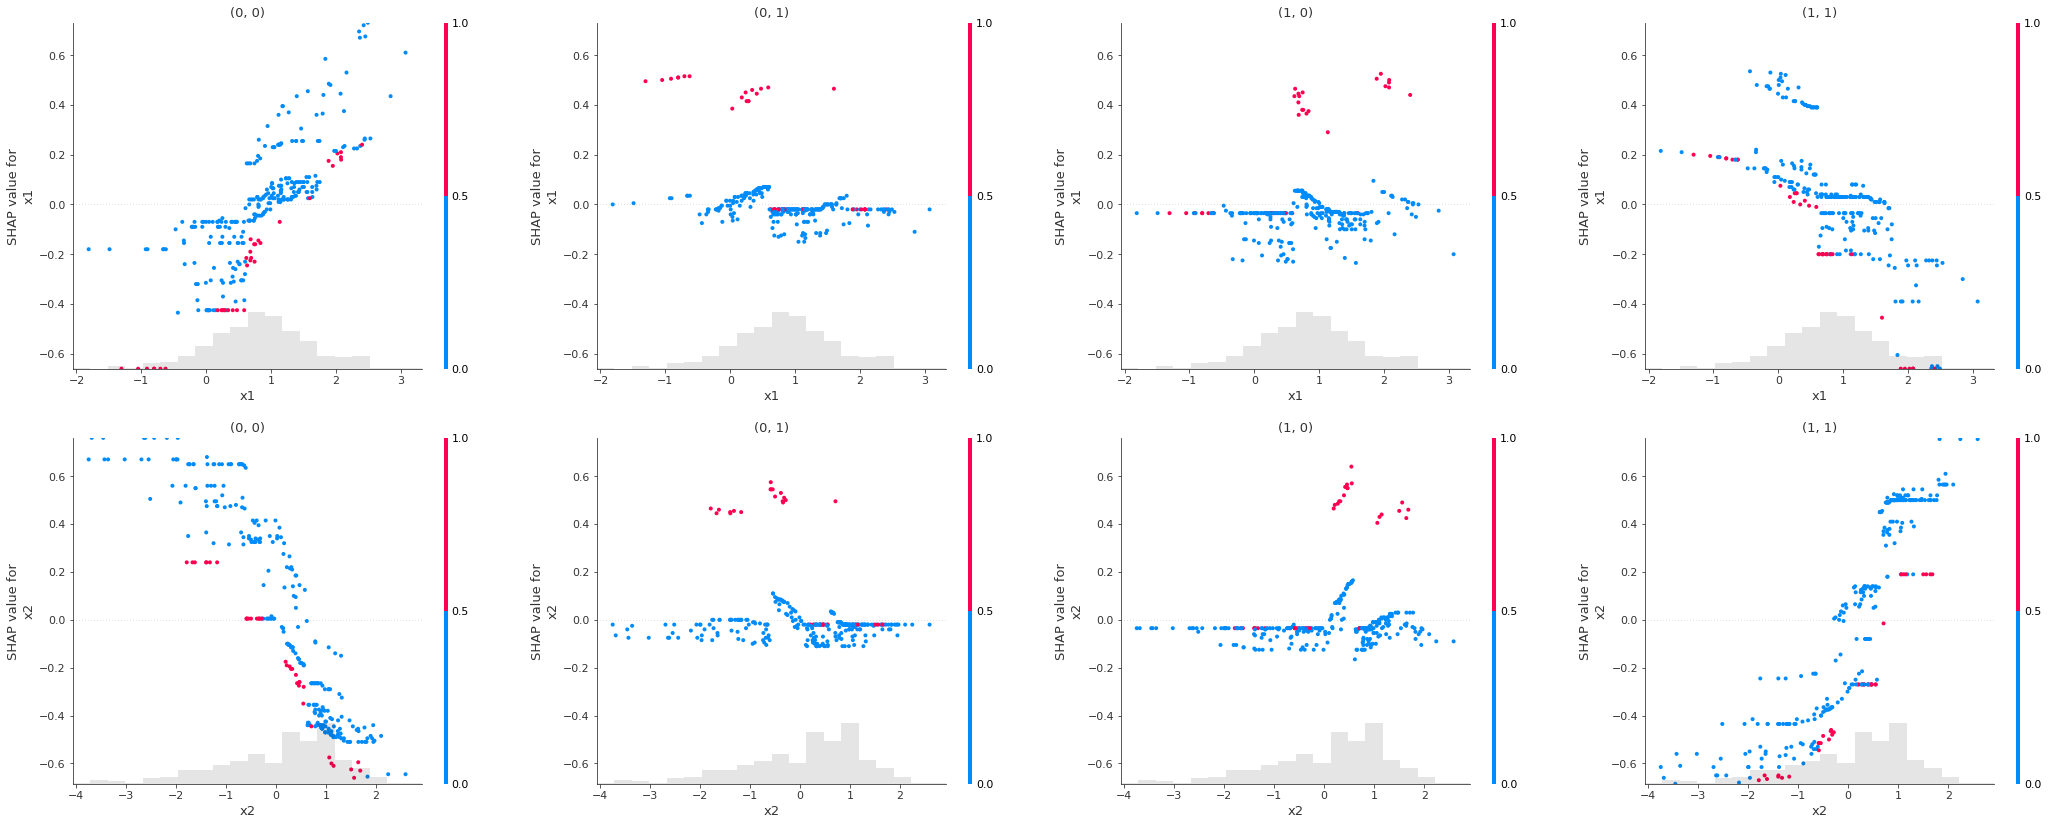

In [24]:
plot_feature_effects(explanations.mclass_diff.labels, color=is_pred_diff)

## Cluster instances

### Individual explanations

In [25]:
instance_order = calc_instance_order(explanations)
plot_forces(explanations.indiv.labels[:, :, 1], instance_order=instance_order)

### Simple subtraction explanation

In [26]:
plot_forces(explanations.indiv_diff.labels, instance_order=instance_order)

### Multiclass difference classifier explanations

In [27]:
plot_forces(explanations.mclass_diff.labels[:, :, comparer.difference_class_names], instance_order=instance_order)